# load bitstream

In [1]:
import sys
import json
import requests
import numpy as np                                                                                         
import matplotlib.pyplot as plt

from ipywidgets import interact, fixed
import ipywidgets as widgets
from IPython.display import Image, display

from time import sleep
from tqdm import tqdm
from attrdict import AttrDict
from datetime import date

sqclib = '/home/xilinx/jupyter_notebooks/nthu/Library'
sys.path.append(sqclib)
from sqckit.labber_toolv2 import InstrManager, hdf5_generator

qick_path = '/home/xilinx/jupyter_notebooks/nthu/Library/qick_lib'
sys.path.append(qick_path)
from qick import *


 bitfile_path = '/home/xilinx/jupyter_notebooks/nthu/sinica-5q/top_216-pfb2.bit'
soc = QickSoc(bitfile = bitfile_path, external_clk = True)
port_map = {'0_230':0, '1_230':1, '2_230':2, '3_230':3,
                '0_231':4, '1_231':5, '2_231':6}
 

soccfg = soc
print(soc)

Load qick_lib to the environment.
Load sqckit to the environment.
Load labber_api to the environment.


resetting clocks: 245.76 491.52

QICK configuration:

	Board: ZCU216

	Software version: 0.2.220
	Firmware timestamp: Mon Jan 15 21:47:46 2024

	Global clocks (MHz): tProcessor 430.080, RF reference 245.760

	7 signal generator channels:
	0:	axis_signal_gen_v6 - envelope memory 65536 samples (9.524 us)
		fs=6881.280 MHz, fabric=430.080 MHz, 32-bit DDS, range=6881.280 MHz
		DAC tile 2, blk 0 is 0_230, on JHC3
	1:	axis_signal_gen_v6 - envelope memory 65536 samples (9.524 us)
		fs=6881.280 MHz, fabric=430.080 MHz, 32-bit DDS, range=6881.280 MHz
		DAC tile 2, blk 1 is 1_230, on JHC4
	2:	axis_signal_gen_v6 - envelope memory 65536 samples (9.524 us)
		fs=6881.280 MHz, fabric=430.080 MHz, 32-bit DDS, range=6881.280 MHz
		DAC tile 2, blk 2 is 2_230, on JHC3
	3:	axis_signal_gen_v6 - envelope memory 65536 samples (9.524 us)
		fs=6881.280 MHz, fabric=430.080 MHz, 32-bit DDS, range=6881.280 MHz
		DAC tile 2, blk 3 is 3_230, on JHC4
	4:	axis_signal_gen_v6 - envelope memory 65536 samples (9.524 us)


# Init instrument

In [4]:

a = InstrManager(server_ip='192.168.10.81')

a.add_instrument(sHardware='Rohde&Schwarz RF Source',
                    dComCfg={'name':'rf_lo',
                            'address': '192.168.10.84',
                            'interface': 'TCPIP'})
a.ctrl.rf_lo.setValue("LO Source", "External")
a.ctrl.rf_lo.setValue("LO Frequency", "10MHZ")

Activate rf_lo successfully.


'10MHZ'

# Build ADC level to power table

## setup

In [2]:

class ADC_readout(AveragerProgram):
    
    def initialize(self):
        
        cfg=self.cfg
        
        for adc_ch in self.cfg['adc_chs']:
            self.declare_readout(
                ch=adc_ch,
                length=cfg["readout_length"],
                freq=cfg["frequency"],
                sel=cfg['readout_sel'])
        
        self.synci(200)
        
    def body(self):
        
        self.trigger(adcs=self.cfg["adc_chs"],
                     adc_trig_offset=self.cfg["adc_trig_offset"])
        
        self.wait_all() 
        self.sync_all(self.cfg["relax_delay"]) 
        


max_power_LO = -1.6 # dBm     

## generate table

In [116]:

a.ctrl.rf_lo.setValue(sQuant="Output", value = True)

n_mag_avg = 1
ADCLevel2Power = dict()

for freq in tqdm(range(100, 1000, 5)):

    ADCLevel2Power[freq] = dict()

    a.ctrl.rf_lo.setValue(sQuant="Frequency", value = freq * 1e6)
    
    meas_cfg={
        "adc_chs": [3], # ADC 0
        "frequency": freq,
        "readout_length":500,
        "adc_trig_offset":0, 
        "readout_sel": "product"
    }
    expt_cfg={"reps":1, "relax_delay":0.1, "soft_avgs": 1}
    config={**meas_cfg, **expt_cfg}


    for power in np.arange(-50, max_power_LO, 0.5):
        power = round(float(power), 2)
        
        if power > max_power_LO:
            print("power too large")
            break

        a.ctrl.rf_lo.setValue(sQuant='Power', value = power)

        ampavg = []
        for i in range(n_mag_avg):
            prog = ADC_readout(soccfg, config)
            avgi, avgq = prog.acquire(soc, load_pulses=True, progress=False)
            ampavg.append(np.abs(avgi[0][0] + 1j*avgq[0][0]))
 
        ADCLevel2Power[freq][power] = round(float(np.mean(ampavg)), 2)
 
    
a.ctrl.rf_lo.setValue(sQuant="Output", value = False)

len(list(ADCLevel2Power.keys())), len(list(ADCLevel2Power[100].keys()))

100%|██████████| 180/180 [01:58<00:00,  1.52it/s]


(180, 97)

## plot table

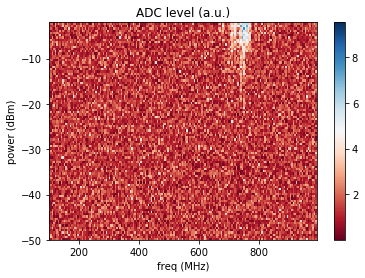

In [117]:
import matplotlib.pyplot as plt
import numpy as np
# ADCLevel2Power = ADCtable
x, y = np.meshgrid(list(ADCLevel2Power.keys()), list(ADCLevel2Power[100].keys()))

z = np.zeros(x.shape)

for i in range(x.shape[0]):
    for j in range(x.shape[1]):
        z[i, j] = ADCLevel2Power[x[i, j]][y[i, j]]
        
fig, ax = plt.subplots()
ax.set_title('ADC level (a.u.)')

plt.pcolormesh(x, y, z, cmap='RdBu', vmin = np.abs(z).min(), vmax = np.abs(z).max())
plt.colorbar()


plt.xlabel("freq (MHz)")
plt.ylabel("power (dBm)")


plt.show()

## save table

In [115]:
import pickle

with open('ADCLevel2Power_balun-1000_top216-pfb2_adc-0.pkl', 'wb') as fp:
    pickle.dump(ADCLevel2Power, fp)

    
# check save    
with open('ADCLevel2Power_balun-1000_top216-pfb2_adc-0.pkl', 'rb') as fp:
    ADCtable = pickle.load(fp)

len(list(ADCtable.keys())), len(list(ADCtable[100].keys()))       

(180, 97)

## print table

In [17]:
import pickle
# check save    
with open('ADCLevel2Power_balun-1000_top216-pfb2_adc-0.pkl', 'rb') as fp:
    ADCtable = pickle.load(fp)

len(list(ADCtable.keys())), len(list(ADCtable[100].keys()))

(180, 97)

In [63]:


print('     ', end='')
for pwr in list(ADCtable[100].keys())[::8]:
    s = str(pwr)
    print(f'{s:>8}', end='')
print()

print('     ', end='')
for pwr in list(ADCtable[100].keys())[::8]:
    s = '________'
    print(f'{s:>8}', end='')
print()

for freq in list(ADCtable.keys())[::5]:
    s = str(freq) + "|"
    print(f'{s:>5}', end='')
    for pwr in list(ADCtable[100].keys())[::8]:
        s = str(round(ADCtable[freq][pwr]))
        print(f'{s:>8}', end='')
    print()

        -50.0   -46.0   -42.0   -38.0   -34.0   -30.0   -26.0   -22.0   -18.0   -14.0   -10.0    -6.0    -2.0
     ________________________________________________________________________________________________________
 100|     126     199     310     487     776    1231    1945    3074    4861    7702   12217   19346   30678
 125|     128     201     308     485     774    1228    1937    3064    4858    7698   12202   19399   30683
 150|     125     192     303     476     758    1201    1891    2992    4756    7514   11925   18980   30006
 175|     128     197     304     478     762    1207    1900    3008    4783    7562   11980   19046   30102
 200|     123     192     296     468     744    1176    1856    2934    4661    7368   11677   18580   29398
 225|     125     193     300     470     751    1185    1881    2977    4728    7478   11848   18787   29722
 250|     123     190     294     462     738    1165    1848    2923    4640    7340   11636   18455   29181
 275|     